In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()


In [8]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

X_train = X_train.reshape(X_train.shape[0], -1)  # (60000, 784)
X_test  = X_test.reshape(X_test.shape[0], -1)


Y_train = to_categorical(y_train, 10)
Y_test  = to_categorical(y_test, 10)

print("Train:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)


Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


In [9]:
def build_model(layer_dims, init="he_normal", reg=None, dropout_rate=0.0, use_bn=True):

    model = models.Sequential(name="mlp_optimizers")

    # First (input) layer
    model.add(layers.Input(shape=(layer_dims[0],)))
    for i in range(1, len(layer_dims)-1):
        model.add(layers.Dense(layer_dims[i],
                               kernel_initializer=init,
                               kernel_regularizer=reg,
                               use_bias=not use_bn))
        if use_bn:
            model.add(layers.BatchNormalization())
            
        model.add(layers.Activation("relu"))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(layer_dims[-1],
                           activation="softmax",
                           kernel_initializer="glorot_uniform"))  

    return model


In [10]:
optimizers_to_try = {
    "SGD": optimizers.SGD(learning_rate=0.01),
    "Momentum": optimizers.SGD(learning_rate=0.01, momentum=0.9),
    "RMSProp": optimizers.RMSprop(learning_rate=0.001),
    "Adam": optimizers.Adam(learning_rate=0.001)
}

In [11]:

results = {}

for name, opt in optimizers_to_try.items():
    print(f"\n Training with {name} ")
    reg = regularizers.l2(1e-4) if name in ["SGD", "Momentum"] else None
    model = build_model([784, 256, 128, 10], reg=reg)   # rebuild fresh model each time
    model.compile(optimizer=opt,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    history = model.fit(
        X_train, Y_train,
        validation_split=0.2,
        epochs=75,
        batch_size=128,
        verbose=0,

    )

    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    results[name] = {
        "history": history.history,
        "test_acc": float(test_acc),
        "test_loss": float(test_loss),
    }
    
    model.save(f"fashion_model_{name.lower()}_no_lrd.h5")
    print(f"{name} → Test Accuracy: {test_acc:.4f}")




 Training with SGD 


2025-08-30 15:44:37.023570: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 15:45:51.077969: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

SGD → Test Accuracy: 0.8716

 Training with Momentum 


2025-08-30 15:47:11.957423: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Momentum → Test Accuracy: 0.8469

 Training with RMSProp 


2025-08-30 15:48:36.477390: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


RMSProp → Test Accuracy: 0.8711

 Training with Adam 


2025-08-30 15:50:06.042487: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Adam → Test Accuracy: 0.8790


SGD        | Test Acc: 0.8716
Momentum   | Test Acc: 0.8469
RMSProp    | Test Acc: 0.8711
Adam       | Test Acc: 0.8790


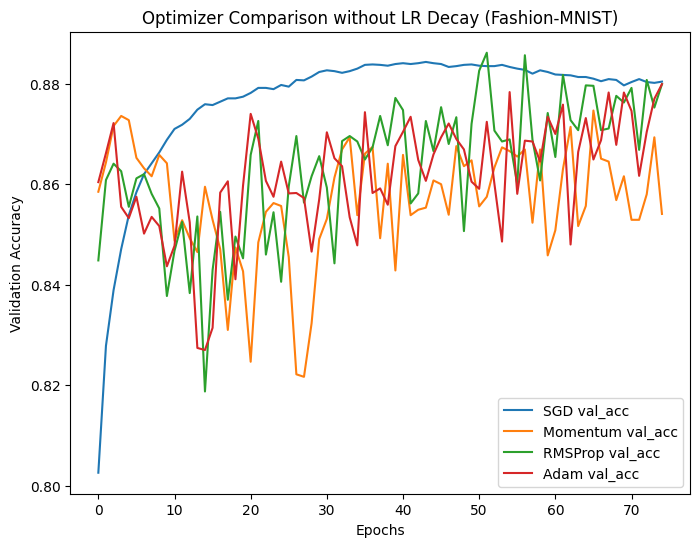

In [12]:
for name, res in results.items():
    print(f"{name:10s} | Test Acc: {res['test_acc']:.4f}")

# Plot validation accuracy curves
plt.figure(figsize=(8,6))
for name, res in results.items():
    plt.plot(res["history"]["val_accuracy"], label=f"{name} val_acc")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Optimizer Comparison without LR Decay (Fashion-MNIST)")
plt.show()


In [13]:
def time_based_decay(initial_lr=0.01, decay=0.01):
    def schedule(epoch, lr):
        return initial_lr / (1.0 + decay * epoch)
    return schedule

DECAY_MAP = {
    "SGD":      0.02,  # ~half-life 50 epochs
    "Momentum": 0.02,
    "RMSProp":  0.01,  # ~half-life 100 epochs
    "Adam":     0.01,
    # "AdamW":  0.01,
}


In [14]:
results_decay = {}

for name, opt in optimizers_to_try.items():
    print(f"\n=== Training {name} with LR decay ===")
    opt_decay = type(opt).from_config(opt.get_config())
    reg = regularizers.l2(1e-4) if name in ["SGD", "Momentum"] else None

    model = build_model([784, 256,128,10], reg=reg, dropout_rate=0.0, use_bn=True)
    model.compile(optimizer=opt_decay,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # initial LR
    try:
        init_lr = float(tf.keras.backend.get_value(opt_decay.learning_rate))
    except:
        init_lr = float(opt_decay.learning_rate)

    decay_factor = DECAY_MAP.get(name, 0.01)
    lrs = LearningRateScheduler(time_based_decay(init_lr, decay_factor))

    # train with LR scheduler
    history = model.fit(
        X_train, Y_train,
        validation_split=0.2,
        epochs=75,
        batch_size=128,
        verbose=0,
        callbacks=[lrs]
    )

    # last-epoch test
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    results_decay[name] = {
        "history": history.history,
        "init_lr": init_lr,
        "decay_factor": decay_factor,
        "test_acc": float(test_acc),
        "test_loss": float(test_loss),
    }

    model.save(f"fashion_model_{name.lower()}_with_lrd.h5")
    print(f"{name} + decay → Test Accuracy: {test_acc:.4f}")



=== Training SGD with LR decay ===


2025-08-30 15:51:03.186585: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 15:52:23.704517: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

SGD + decay → Test Accuracy: 0.8798

=== Training Momentum with LR decay ===


2025-08-30 15:53:50.658092: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Momentum + decay → Test Accuracy: 0.8864

=== Training RMSProp with LR decay ===


2025-08-30 15:55:23.503766: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


RMSProp + decay → Test Accuracy: 0.8784

=== Training Adam with LR decay ===


2025-08-30 15:56:55.502734: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Adam + decay → Test Accuracy: 0.8803


SGD        | Test Acc: 0.8798
Momentum   | Test Acc: 0.8864
RMSProp    | Test Acc: 0.8784
Adam       | Test Acc: 0.8803


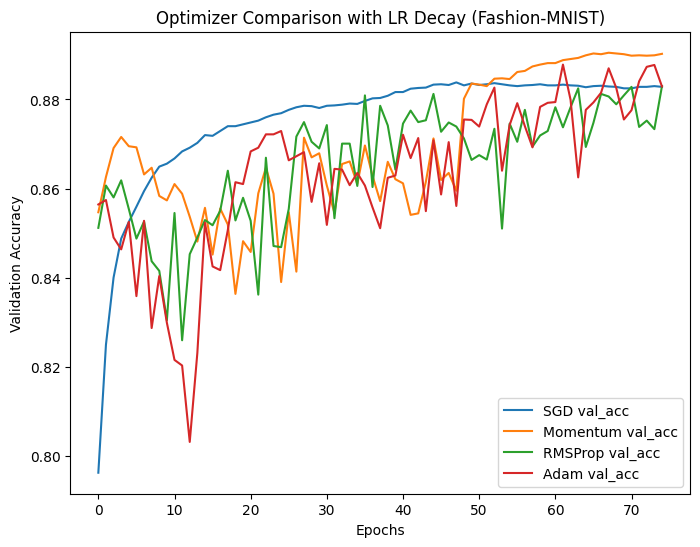

In [15]:
# Print test accuracies
for name, res in results_decay.items():
    print(f"{name:10s} | Test Acc: {res['test_acc']:.4f}")

# Plot validation accuracy curves
plt.figure(figsize=(8,6))
for name, res in results_decay.items():
    plt.plot(res["history"]["val_accuracy"], label=f"{name} val_acc")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Optimizer Comparison with LR Decay (Fashion-MNIST)")
plt.show()

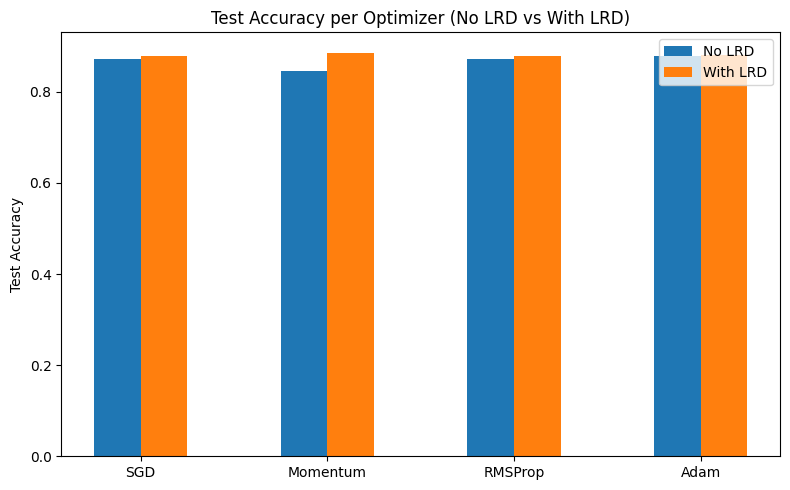

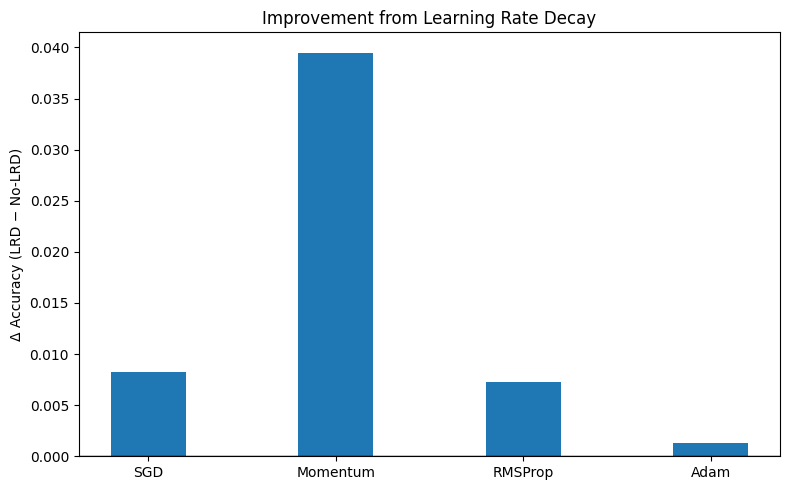

optimizer  no_lrd    lrd  delta
 Momentum  0.8469 0.8864 0.0395
     Adam  0.8790 0.8803 0.0013
      SGD  0.8716 0.8798 0.0082
  RMSProp  0.8711 0.8784 0.0073


In [16]:
import numpy as np
import matplotlib.pyplot as plt

names = [k for k in optimizers_to_try.keys() if k in results and k in results_decay]

acc_no  = [results[n]["test_acc"]        for n in names]
acc_lrd = [results_decay[n]["test_acc"]  for n in names]

x = np.arange(len(names))
w = 0.25   # smaller width than before (was 0.35)

# --------- grouped bar: No-LRD vs LRD ----------
plt.figure(figsize=(8,5))
plt.bar(x - w/2, acc_no,  width=w, label="No LRD")
plt.bar(x + w/2, acc_lrd, width=w, label="With LRD")
plt.xticks(x, names)
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy per Optimizer (No LRD vs With LRD)")
plt.legend()
plt.tight_layout()
plt.show()

# --------- delta bar: (LRD − No-LRD) ----------
delta = [b - a for a, b in zip(acc_no, acc_lrd)]
plt.figure(figsize=(8,5))
plt.bar(names, delta, width=0.4)   # also slimmer bars here
plt.axhline(0, linewidth=1, color="black")
plt.ylabel("Δ Accuracy (LRD − No-LRD)")
plt.title("Improvement from Learning Rate Decay")
plt.tight_layout()
plt.show()

df = pd.DataFrame({
    "optimizer": names,
    "no_lrd": acc_no,
    "lrd": acc_lrd,
    "delta": delta
}).sort_values("lrd", ascending=False)
print(df.to_string(index=False, float_format=lambda v: f"{v:.4f}"))
